In [1]:
import urllib.request
import datetime as dt

# define riometer readfile function
def rio_readfile(url):

    # Define lists
    date = [] #do i even need the date cause it's the same year?
    time = []
    absorption = []
    raw_sig = []

    # Define filename
    #filename = "RD 2012-03-03.txt"

    # open file to read
    response = urllib.request.urlopen(url)
    html_response = response.read()
    encoding = response.headers.get_content_charset("utf-8")
    fp = html_response.decode(encoding)

    # define new list sanitized_data
    # entry = [] list defined later, append datetime, absp, raw sig to it
    # later append entry to sanitized_data so it will be lists within a list
    sanitized_data = []
    
    for line in fp.splitlines():
        #print(line)
        #print(str(line))
    
        # skip comments
        if line[0] == "#":
            continue
        else:
            
            # strip line
            line_strip = line.strip()
            # split lines into lists
            line_split = line.split()
            #print(line_split[1])

            # Define datetime format for date and time
            
            format = "%d%m%Y%H:%M:%S"
            
            # split column 0 to month, date, year and make one row
            month = str(line_split[0].split("/")[1])
            day = str(line_split[0].split("/")[0])
            year = "20" + str(line_split[0].split("/")[2])
                      
            full_date = day + month + year + str(line_split[1])
            
            # Try-except to see if can convert to datetime
            try:
                res = bool(dt.datetime.strptime(full_date, format))
                this_time = dt.datetime.strptime(full_date, format)
                
                # Get rid of negative absorption values
                if float(line_split[2]) < 0:
                    continue
                # Only append line to list if time checks true

                # append time to array
                time.append(this_time)
                # append absorption to array
                absorption.append(float(line_split[2]))
                # append raw signals to array
                raw_sig.append(line_split[3])

                # define new list 
                entry = []
                entry.append(this_time)
                entry.append(line_split[2])
                entry.append(line_split[3])
                
                sanitized_data.append(entry)
                    
            except ValueError:
                res = False

    #return sanitized_data
    return sanitized_data
    #return absorption
    #return raw_sig

In [2]:
## Import stuff
import numpy as np

def ionosonde_plotter(f):
    # Define timestamp array
    timestamp_full = []

    # Minimum virtual height of E trace
    sanitized_hE = []
    # Minimum virtual height of Es trace
    sanitized_hEs = []
    # Define CS array
    CS = []

    # E layer critical frequency
    sanitized_foE = []
    # Es layer critical frequency
    sanitized_foEs = []


    # Define filename
    filename = f

    # define indices for each parameter of file
    time_idx = 0
    CS_idx = 1
    foEs_idx = 2
    foE_idx = 4
    hE_idx = 6
    hEs_idx = 8

    # Define format for datetime
    format = "%Y-%m-%dT%H:%M:%S.%fZ"

    # Open file - read
    fp = f
    # Read every line in file
    for line in fp:
    # Skip comments
        if line[0] == "#":
            continue
    # Strip lines
        else:
            line_strip = line.strip()
    # Split lines into lists
            line_split = line.split()

            foE_str = line_split[foE_idx]
            foEs_str = line_split[foEs_idx]
            hE_str = line_split[hE_idx]
            hEs_str = line_split[hEs_idx]

            timestamp_full.append(dt.datetime.strptime(line_split[time_idx], format))

            # Check if can convert foE to float
            try:
                foE_float = float(foE_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = dt.datetime.strptime(timestamp_str, format)
                sanitized_foE.append([timestamp_datetime, foE_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

            # Check if can convert foEs to float
            try:
                foEs_float = float(foEs_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = dt.datetime.strptime(timestamp_str, format)
                sanitized_foEs.append([timestamp_datetime, foEs_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

            # Check if hE can convert to float
            try:
                hE_float = float(hE_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = dt.datetime.strptime(timestamp_str, format)
                sanitized_hE.append([timestamp_datetime, hE_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

            # Check if hEs can convert to float
            try:
                hEs_float = float(hEs_str)
                # Extract timestamp and append to the array
                timestamp_str = line_split[time_idx]
                timestamp_datetime = dt.datetime.strptime(timestamp_str, format)
                sanitized_hEs.append([timestamp_datetime, hEs_float])
            except ValueError:
                # If the conversion fails, ignore the line
                pass

    return sanitized_hEs, sanitized_foEs


In [3]:
def absorption_svn_avg(sanitized_data, sanitized_hEs):
    # start rio measurements from the time its and hEs's times align
    index_to_start = None
    
    for i in range(len(sanitized_data)):
        if sanitized_data[i][0].minute == sanitized_hEs[0][0].minute:
            #print(sanitized_data[i][0].minute, sanitized_hEs[0][0].minute)
            index_to_start = i
            break

    count = 0
    sum_avg = 0
    svn_avg_absp = []
    #l = 0
    i = 0
    
    if index_to_start == 0:
        index_to_start = 1

    # go through san_data list from first minute that aligns with first hEs measurement
    for index, measurement in enumerate(sanitized_data[(index_to_start-1):]):
        if i < (len(sanitized_hEs)-1):
            #print(i)
            if measurement[0].minute != sanitized_hEs[i+1][0].minute:
                #print(measurement[0].minute, sanitized_hEs[i+1][0].minute)
                # add measurement[1] to sum to get the average
                sum_avg += float(measurement[1])
                count+= 1
                continue
            else:
                if i != (len(sanitized_hEs)-1):
                    svn_avg_absp.append([sanitized_hEs[i][0], sum_avg/count, sanitized_hEs[i][1]])
                # reset sum to whatever measurement we're looking at now
                sum_avg = float(measurement[1])
                count = 1
                i+=1
        else:
            sum_avg += float(measurement[1])
            count+=1
            #print(sum_avg, count)

    svn_avg_absp.append([sanitized_hEs[i][0], sum_avg/count, sanitized_hEs[i][1]])

    return svn_avg_absp
            

In [4]:
# List the days needed as strings
import datetime as dt

format = "%Y-%m-%d"
##### 1.  2012-01-23
##### 2.  2012-02-07
##### 3.  2012-03-01
##### 4.  2012-03-07
##### 5.  2012-03-08
##### 6.  2012-03-13
##### 7.  2012-03-15
##### 8.  2012-04-03
##### 9.  2012-04-25
##### 10. 2012-07-06
##### 11. 2012-11-01
##### 12. 2012-11-07
days_to_analyze_string = ["2012-01-23", "2012-02-07", "2012-03-01", "2012-03-07", "2012-03-08", "2012-03-13", "2012-03-15", "2012-04-03", "2012-04-25", "2012-07-06", "2012-11-01", "2012-11-07"]

days_to_analyze = []

for day in days_to_analyze_string:
    day_datetime = dt.datetime.strptime(day, format)
    days_to_analyze.append(day_datetime)

print(days_to_analyze)
print(days_to_analyze[11])

[datetime.datetime(2012, 1, 23, 0, 0), datetime.datetime(2012, 2, 7, 0, 0), datetime.datetime(2012, 3, 1, 0, 0), datetime.datetime(2012, 3, 7, 0, 0), datetime.datetime(2012, 3, 8, 0, 0), datetime.datetime(2012, 3, 13, 0, 0), datetime.datetime(2012, 3, 15, 0, 0), datetime.datetime(2012, 4, 3, 0, 0), datetime.datetime(2012, 4, 25, 0, 0), datetime.datetime(2012, 7, 6, 0, 0), datetime.datetime(2012, 11, 1, 0, 0), datetime.datetime(2012, 11, 7, 0, 0)]
2012-11-07 00:00:00


In [5]:
import os
import matplotlib.pyplot as plt

colors = ['indianred','seagreen','cyan','goldenrod','indigo','navy','darkgreen','peru','cadetblue','firebrick','purple','darkred']

directory = r"C:\Users\minod\OneDrive\Documents\UCalgary\Winter 2024\phys 598 - thesis\Jupyter files\Final paper\Riometer seasonal track\Trends\txt files"

total_svn_avg_absp_hEs = []
total_svn_avg_absp_foEs = []

for idx, ionosonde_txt_file in enumerate(os.listdir(directory)):
    #print(idx)
    if ionosonde_txt_file.endswith(".txt"):
        with open(os.path.join(directory, ionosonde_txt_file)) as f:
            #print(f)
            sanitized_hEs, sanitized_foEs = ionosonde_plotter(f)
            if idx <= 12:
                #print(idx-1)
                date = days_to_analyze[idx-1]
                #print(date)
                #print(idx)
            
                year_str = str(date.year)
                month_str = str(date.month).zfill(2)
                day_str = str(date.day).zfill(2)
            
                new_base = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/{year}/{month}/{day}/norstar_k2_rio-daws_{year}{month}{day}_v01.txt"
            
                sanitized_data = rio_readfile(new_base.format(year=year_str, month=month_str, day=day_str))
            
                # apply the function
                svn_avg_absp_hEs = absorption_svn_avg(sanitized_data, sanitized_hEs)

                svn_avg_absp_foEs = absorption_svn_avg(sanitized_data, sanitized_foEs)
                total_svn_avg_absp_hEs.append(svn_avg_absp_hEs)
                print(len(total_svn_avg_absp_hEs))
                total_svn_avg_absp_foEs.append(svn_avg_absp_foEs)

#print(total_svn_avg_absp_hEs)

1
2
3
4
5
6
7
8
9
10
11
12


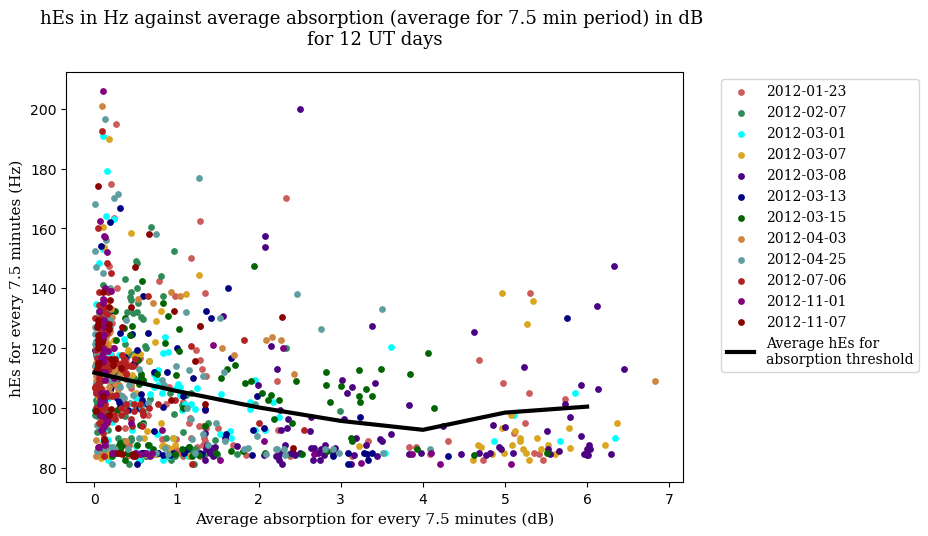

In [6]:
plt.figure(figsize=(10,6))
plt.xlabel("Average absorption for every 7.5 minutes (dB)", fontdict={'family': 'serif', 'size': 11}) 
plt.ylabel("hEs for every 7.5 minutes (Hz)", fontdict={'family': 'serif', 'size': 11}) 
plt.title("hEs in Hz against average absorption (average for 7.5 min period) in dB \nfor 12 UT days",pad=20, fontdict={'family': 'serif', 'size': 13})

absp_thresh = []

for index, day in enumerate(total_svn_avg_absp_hEs):
    #print(day)
    # x is absorption
    # y is hEs
    x_hEs_absp = [point[1] for point in day]
    y_hEs = [point[2] for point in day]

    
    hEs_dict_unsorted = dict(zip(x_hEs_absp, y_hEs))
    hEs_dict = dict(sorted(hEs_dict_unsorted.items()))

    sum_avg = 0
    count = 0
    for i in range(0,7):
        for item in hEs_dict.items():
            if item[0] >= i and item[0]<(i+1):
                sum_avg += item[1]
                count += 1
        if count!= 0:
            absp_thresh.append([i, float(sum_avg/count)])
            sum_avg=0
            count=0
    
    datetime_string = days_to_analyze[index].strftime('%Y-%m-%d')
    plt.scatter(x_hEs_absp,y_hEs, s=15, color=colors[index],label=datetime_string)


absp_thresh = sorted(absp_thresh, key=lambda x:x[0])

final_final_avg_thresh = []
final_sum = 0
final_count = 0

for i in range(0,7):
    for item in absp_thresh:
        if item[0] == i:
            final_sum += item[1]
            final_count += 1
    if final_count != 0:
        final_final_avg_thresh.append([i, final_sum/final_count])
    final_sum = item[1]
    final_count = 1

plt.plot([point[0] for point in final_final_avg_thresh], [point[1] for point in final_final_avg_thresh], linestyle='-', color='black', linewidth=3, label='Average hEs for \nabsorption threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'family': 'serif', 'size': 10})
plt.tight_layout(pad=3.0)
plt.savefig("hEs_vs_absp_7.5_minutes_TRENDLINE.png")
plt.show()
